# Data exploration/wrangling

Enter the folder path of the data :

In [47]:
path = "C:/Users/GALLICE/Documents/Perso/Etudes/DSTI/Cours/Survival Analysis/project/Data/crunchbase-october-2013-master/"
path

[1] "C:/Users/GALLICE/Documents/Perso/Etudes/DSTI/Cours/Survival Analysis/project/Data/crunchbase-october-2013-master/"

In [48]:
#-------------import of companies.csv---------------#

datafile = "crunchbase-companies.csv"
startups <- read.csv(paste(path,datafile, sep= ""), 
                     sep = ',',
                     stringsAsFactors = FALSE)


startups$funding_total_usd <- as.integer(startups$funding_total_usd)

startups$category_code <- factor(x = startups$category_code, ordered = FALSE)
startups$status <- factor(startups$status, ordered = FALSE)
startups$country_code <- factor(startups$country_code, ordered = FALSE)
startups$state_code <- factor(startups$state_code, ordered = FALSE)
startups$region <- factor(startups$region, ordered = FALSE)
startups$city <- factor(startups$city, ordered=FALSE)

startups$founded_at <- as.Date(startups$founded_at, "%Y-%m-%d")
startups$first_funding_at <- as.Date(as.character(startups$first_funding_at, format="%Y-%m-%d"))
startups$last_funding_at <- as.Date(as.character(startups$last_funding_at, format="%Y-%m-%d"))
startups$last_milestone_at <- as.Date(as.character(startups$last_milestone_at, format="%Y-%m-%d"))


names(startups)[2] <- "company_name"

summary(startups)

Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion to integer range"

  permalink         company_name           category_code  funding_total_usd  
 Length:17727       Length:17727       software   :2688   Min.   :2.910e+02  
 Class :character   Class :character   biotech    :2060   1st Qu.:7.835e+05  
 Mode  :character   Mode  :character   web        :1662   Median :3.721e+06  
                                       mobile     :1135   Mean   :1.625e+07  
                                       enterprise :1125   3rd Qu.:1.450e+07  
                                       advertising: 739   Max.   :1.654e+09  
                                       (Other)    :8318   NA's   :1523       
       status      country_code   state_code             region    
 acquired : 1673   USA:17727    CA     :6658   SF Bay       :4819  
 closed   :  553                NY     :1837   New York     :1741  
 ipo      :  344                MA     :1425   Boston       :1367  
 operating:15157                TX     : 836   Los Angeles  :1126  
                                WA  

We see that USA is the only country represented

The next chunk of code computes the lifetime vector of startups. We use foundation date as the start date, and l

In [49]:
start_date <- startups$founded_at

startups$last_milestone_at[is.na(startups$last_milestone_at)] <- startups$last_funding_at[is.na(startups$last_milestone_at)]#imputes missing dates in last_milestone_at

end_date <- startups$last_milestone_at

if(FALSE){
end_date <- startups$last_funding_at #or end_date <- startups$last_milestone_at ?
                                     #for startups that are acquired, the last_milestone could be better
                                     # startups[which(startups$status=="acquired"), c("last_funding_at","last_milestone_at")]
}

days_of_existence <- data.frame(matrix(data = NA,nrow = dim(startups)[1], ncol = 1))

for(i in seq(1,dim(startups)[1])){
  days_of_existence[i,] <- as.integer(end_date[i]-start_date[i])
  if(!is.na(days_of_existence[i,])){
    if(days_of_existence[i,] <= 30){
      days_of_existence[i,] <- NA
    }
  }
}

#create column for lifetime of the startup
names(days_of_existence) <- "days_of_existence"
summary(days_of_existence)
startups <- cbind(startups,days_of_existence)

startups <- startups[!is.na(days_of_existence),]
startups <- startups[!is.na(startups$funding_total_usd),]

rm(days_of_existence)

 days_of_existence
 Min.   :   31    
 1st Qu.:  643    
 Median : 1393    
 Mean   : 2027    
 3rd Qu.: 2646    
 Max.   :39092    
 NA's   :5560     

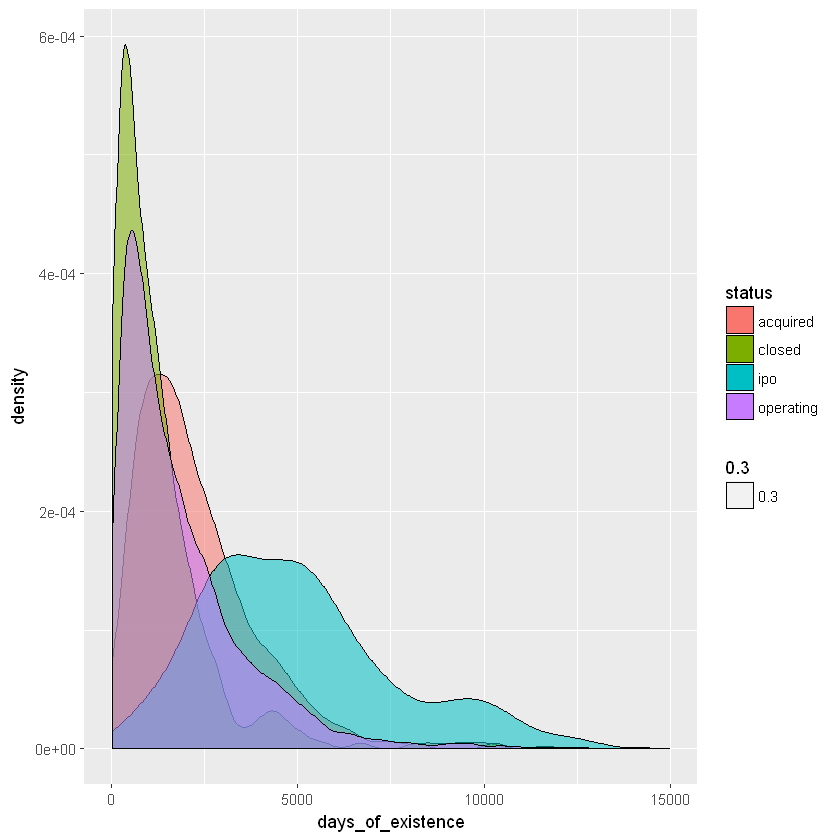

In [50]:
library(ggplot2)

graph_area_subset <- startups[c("days_of_existence", "status", "funding_total_usd", "category_code")]
graph_area_subset <- graph_area_subset[graph_area_subset$days_of_existence<15000,]

ggplot(data=graph_area_subset,aes(x=days_of_existence, group=status, fill=status, alpha=0.3)) + geom_density() 

Graph explanation here

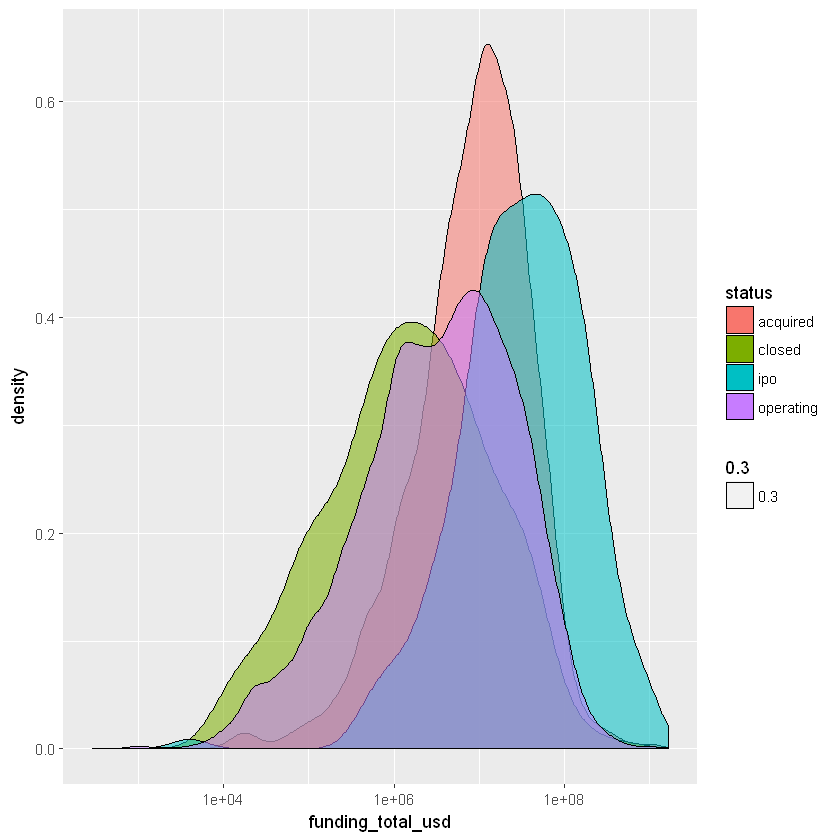

In [51]:
ggplot(data=graph_area_subset,aes(x=funding_total_usd, group=status, fill=status, alpha=0.3)) + geom_density() + scale_x_log10()

rm(graph_area_subset)

Graph explanation here

In [52]:
table(startups$status)


 acquired    closed       ipo operating 
     1230       321       218      9562 

Each startup is assigned a status. For the analysis, we'll assume a startup has reached its end when it is either acquired or closed.

In [53]:
#------------Create target column from the status column-----------#

target <- data.frame(matrix(data = NA,nrow = dim(startups)[1], ncol = 1))
names(target) <- "target"

for (i in seq(1, dim(startups)[1])){
  startup_status <- startups$status[i]
  if (startup_status == 'acquired'){
    target[i,1] <-  1
  }
  else if (startup_status == 'ipo'){
    target[i,1] <- 0
  }
  else if (startup_status == 'operating'){
    target[i,1] <- 0
  }
  else if (startup_status == "closed"){
    target[i,1] <- 1
  }
}

startups <- cbind(startups,target)
rm(target)

#___________target column created______________#


The following plot shows the repartition of events among the different categories of startups.
First 5 categories (in terms of counts) are : 
    
    - Software
    - Biotech
    - Web
    - Enterprise
    - Mobile

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

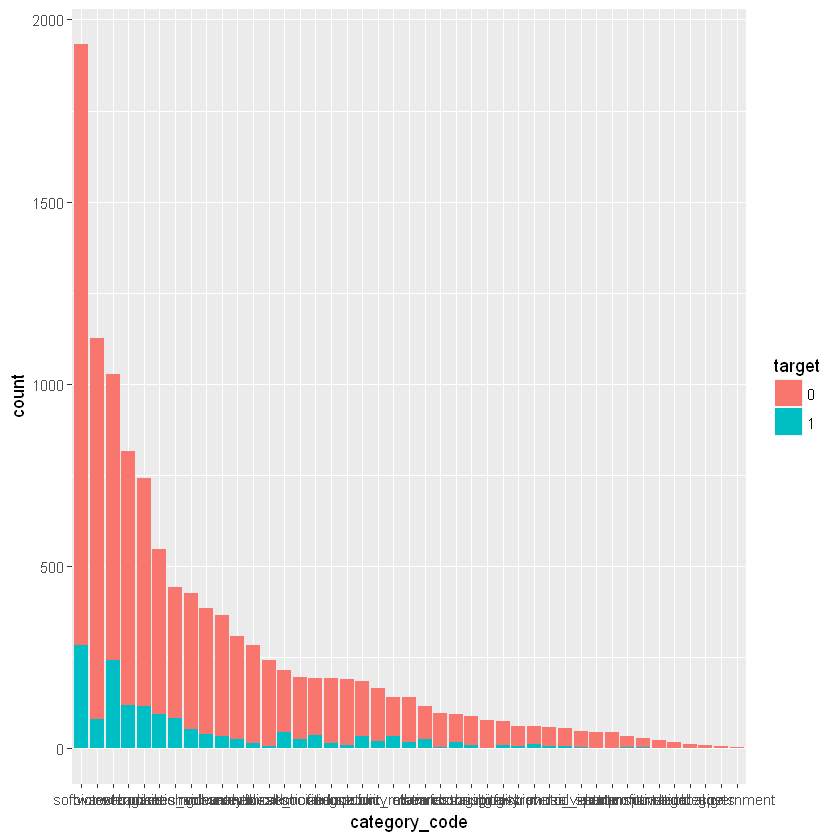

In [54]:
graph_area_subset <- startups[c("days_of_existence", "target","category_code")]
categories <- graph_area_subset$category_code
t_categories <- data.frame(table(categories))
t_categories <- t_categories[order(t_categories$Freq, decreasing=T),]
graph_area_subset$category_code <- factor(graph_area_subset$category_code, levels=t_categories$categories, ordered=T)
graph_area_subset$target <- factor(graph_area_subset$target)

ggplot(data=graph_area_subset,aes(x=category_code, group=target, fill=target)) + geom_histogram(stat="count") 

rm(categories)
rm(t_categories)
rm(graph_area_subset)

It seems that Biotech companies have a lower stopping rate than the other first categories.

Now, let's explore the time repartition of data

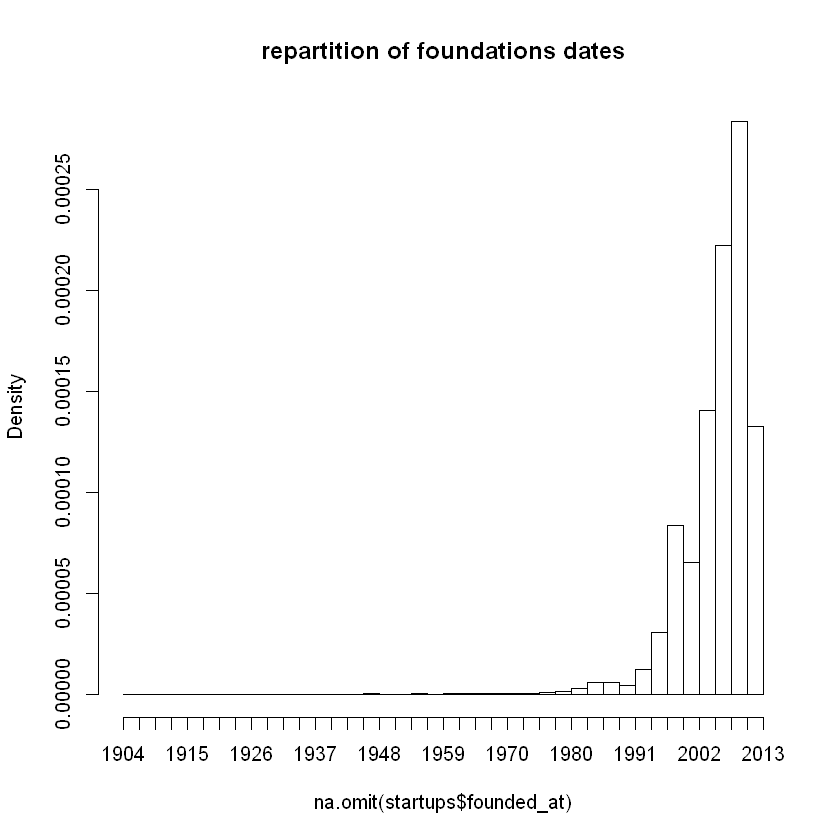

In [55]:
hist(na.omit(startups$founded_at), breaks = 30, main="repartition of foundations dates")

Some outliers before 1990 are visible

### You can change the lower limit for foundation date here :

In [56]:
lower_date_limit <- "1990-01-01"
lower_date_limit #%Y-%m-%d

[1] "1990-01-01"

We then proceed to remove the startups founded prior to this date

In [57]:
#----------removes the values prior to the lower_date_limit--------------#
rows_to_remove <- startups$founded_at < lower_date_limit
rows_to_remove[is.na(rows_to_remove)] <- TRUE

startups <- startups[!rows_to_remove,]


#TODO : impute missing values in funding_total_usd from raised_amount_usd


#______________removes the values prior to the lower_date_limit_____________#

### You can change the upper limit for the censoring date here, in years :

In [58]:
censoring_years = 15
censoring_years

[1] 15

[1] 5475

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


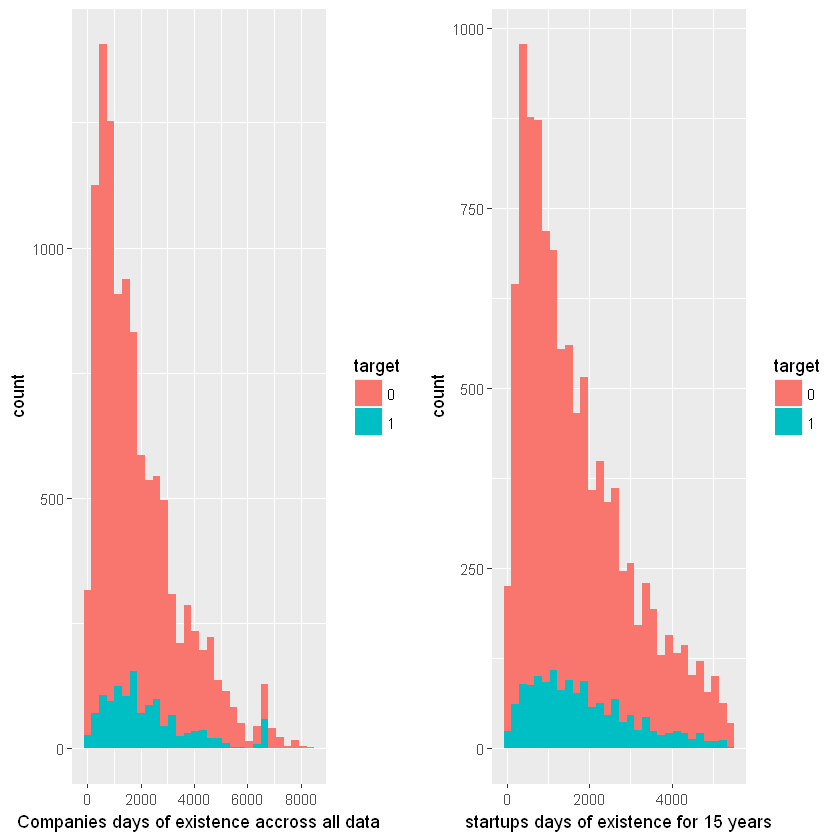

In [59]:
library(gridExtra)


censoring_date <- censoring_years*365
censoring_date

graph_area_subset <- startups[c("days_of_existence", "target")]
graph_area_subset$target <- factor(graph_area_subset$target)

plot1 <- ggplot(data = graph_area_subset[graph_area_subset$days_of_existence,], 
                aes(x=days_of_existence, group=target, fill=target)) + geom_histogram() + xlab("Companies days of existence accross all data")
        
plot2 <- ggplot(data = graph_area_subset[graph_area_subset$days_of_existence < censoring_date,],
                aes(x=days_of_existence, group=target, fill=target)) + geom_histogram() + xlab(paste("startups days of existence for", censoring_years, "years", sep=" "))

grid.arrange(plot1, plot2, ncol=2)

rm(graph_area_subset)

We notice that the stopping distribution for 8 years seems to follow a uniform law. Days of existence will not be a significative variable for this duration.

we load a second dataset, rounds of funding. It provides additionnal information on the different fundings raised by each startup.

In [60]:
#----------handling rounds.csv-----------#
library(dplyr)

datafile = "crunchbase-rounds.csv"

rounds <- read.csv(paste(path,datafile, sep= ""), 
                     sep = ',',
                     stringsAsFactors = FALSE)

#sort rounds dataset by startup name
rounds$company_name <- factor(rounds$company_name)
rounds <- rounds[order(rounds$company_name),]
rounds$company_name <- sapply(rounds$company_name, as.character)

rounds$funding_round_type <- factor(rounds$funding_round_type)

str(rounds)
#_____________done with rounds____________#

'data.frame':	31679 obs. of  13 variables:
 $ company_permalink    : chr  "/company/n-plusn" "/company/waywire" "/company/club-domains" "/company/pay-mobile-checkout-for-email-and-the-web" ...
 $ company_name         : chr  "#NAME?" "#waywire" ".Club Domains" "@Pay - Two-Click Checkout" ...
 $ company_category_code: chr  "software" "news" "software" "mobile" ...
 $ company_country_code : chr  "USA" "USA" "USA" "USA" ...
 $ company_state_code   : chr  "NY" "NY" "FL" "NM" ...
 $ company_region       : chr  "New York" "New York" "Fort Lauderdale" "Albuquerque" ...
 $ company_city         : chr  "New York" "New York" "Oakland Park" "Albuquerque" ...
 $ funding_round_type   : Factor w/ 9 levels "angel","crowdfunding",..: 1 6 7 6 6 9 7 3 1 9 ...
 $ funded_at            : chr  "2012-08-29" "2012-06-30" "2013-05-31" "2012-07-01" ...
 $ funded_month         : chr  "2012-08" "2012-06" "2013-05" "2012-07" ...
 $ funded_quarter       : chr  "2012-Q3" "2012-Q2" "2013-Q2" "2012-Q3" ...
 $ funded_yea

And we explore rounds.csv :

In [61]:
table_df <- data.frame(table(rounds$company_name))

sum(table_df$Freq > 1)/length(table_df$Freq)

[1] 0.4174895

41% of rounds are associated to more than 1 company

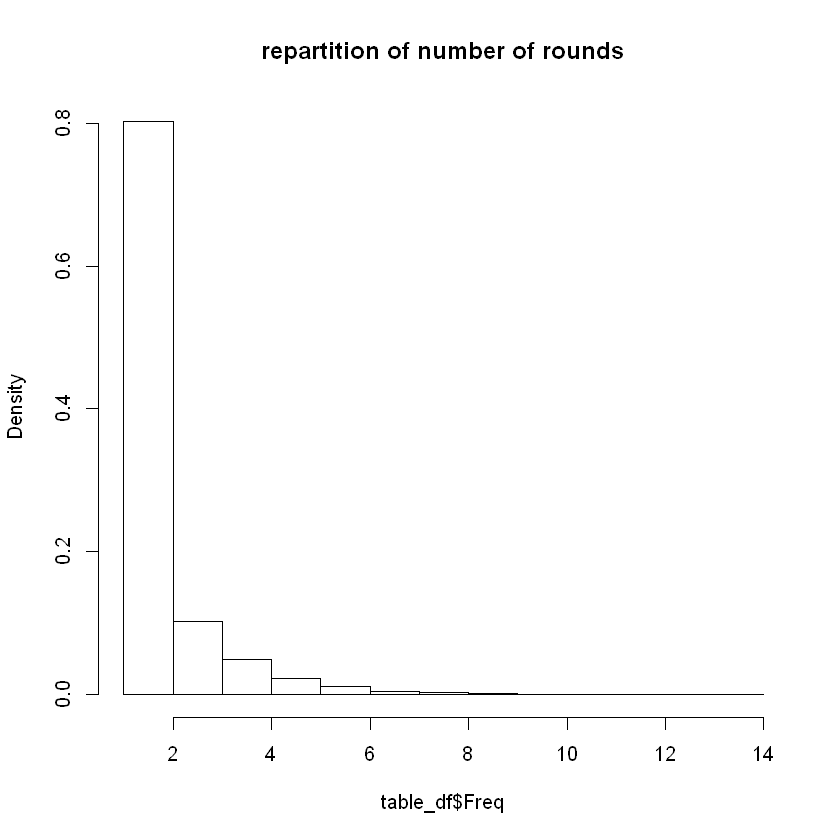

In [62]:
hist(table_df$Freq, freq = F, main="repartition of number of rounds")
rm(table_df)

# Survival analysis

We want to study the impact of the following variables on the survival model :

 - total_funding_usd
 - funding_round_type
 - raised_amount_usd  (Money invested in 1 round)
 
We need to complete each line of the first dataset (companies, named startup in the code) with the corresponding fundings types, the funded amount associated, and their count.
 

We're studying startups that have been founded after this date : 

In [63]:
lower_date_limit

[1] "1990-01-01"

And we're using the following limit for censoring (in years) :

In [64]:
censoring_years

[1] 15

In [65]:
library(survival)

#converting factor funding_rounds from rounds, to columns of count of this factor

funding_round_type_surv_shaped <- data.frame(matrix(data = 0, nrow=dim(startups)[1], ncol = 19))
col_names_fund_round_type <- levels(rounds$funding_round_type)
types_counts <- paste("count_",levels(rounds$funding_round_type), sep="")
names(funding_round_type_surv_shaped) <- c("company_name",col_names_fund_round_type, types_counts)

for (i in 1:dim(funding_round_type_surv_shaped)[1]){
  name <- startups$company_name[i]
  funding_round_type_surv_shaped[i,1] <- name
  funding_rounds <- as.character(rounds$funding_round_type[which(rounds$company_name == name)])#get all funding rounds type for startup i 
  if (length(funding_rounds) > 0){
    for (j in 1:length(funding_rounds)){
      if (is.numeric(rounds$raised_amount_usd[which(rounds$company_name == name)][j])){
        #adds value
        funding_round_type_surv_shaped[i,funding_rounds[j]] <- rounds$raised_amount_usd[which(rounds$company_name == name)][j]
                                                             + funding_round_type_surv_shaped[i,funding_rounds[j]]
      }
      else{
        funding_round_type_surv_shaped[i,funding_rounds[j]] <- NA
      }
      
      #adds count to correponding type
      funding_round_type_surv_shaped[i,paste("count_", funding_rounds[j], sep ="")] <- 1 + funding_round_type_surv_shaped[i,paste("count_", funding_rounds[j], sep ="")]
      
    }
  } 
}

Then, we merge the newly obtained funding_rounds data with a subset of companies data, and we remove rows containing NAs.

In [66]:
#shaping dataframe for survival analysis


censoring_filter <- function(x){
  if((x >censoring_date) || (x == 0)){
    return(TRUE)
  }
  else{
    return(FALSE)
  }
}

rows_to_remove <- sapply(startups$days_of_existence, censoring_filter )  #applying the censoring filter
rows_to_remove[is.na(rows_to_remove)] <- TRUE #also removing rows with NA lifetime

temp_startups <- startups[!rows_to_remove,]



surv_target <- Surv(time = temp_startups$days_of_existence, event = temp_startups$target)

surv_dataframe <- temp_startups[c("company_name","category_code", "funding_total_usd", "funding_rounds")]
surv_dataframe <- left_join(surv_dataframe, funding_round_type_surv_shaped, by="company_name")
surv_dataframe <- data.frame(surv_dataframe,surv_target)
surv_dataframe <- surv_dataframe[,-1]

rm(temp_startups)
rm(funding_round_type_surv_shaped)
str(surv_dataframe)

'data.frame':	10726 obs. of  22 variables:
 $ category_code       : Factor w/ 43 levels "","advertising",..: 28 39 39 9 43 3 39 5 39 39 ...
 $ funding_total_usd   : int  1750000 600000 7000000 750000 2535000 1250000 35000000 3000000 77500 719000 ...
 $ funding_rounds      : int  1 1 1 2 2 2 1 1 1 4 ...
 $ angel               : num  0 600000 0 0 15000 750000 0 0 0 500000 ...
 $ crowdfunding        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ other               : num  0 0 0 500000 0 0 0 3000000 77500 150000 ...
 $ post.ipo            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ private.equity      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ series.a            : num  1750000 0 0 0 2520000 0 0 0 0 0 ...
 $ series.b            : num  0e+00 0e+00 7e+06 0e+00 0e+00 0e+00 0e+00 0e+00 0e+00 0e+00 ...
 $ series.c.           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ venture             : num  0.0 0.0 0.0 0.0 0.0 5.0e+05 3.5e+07 0.0 0.0 0.0 ...
 $ count_angel         : num  0 1 0 0 1 1 0 0 0 3 ...
 $ count_crowdfunding  : num  0 0 0 0

Now, survival analysis can start :

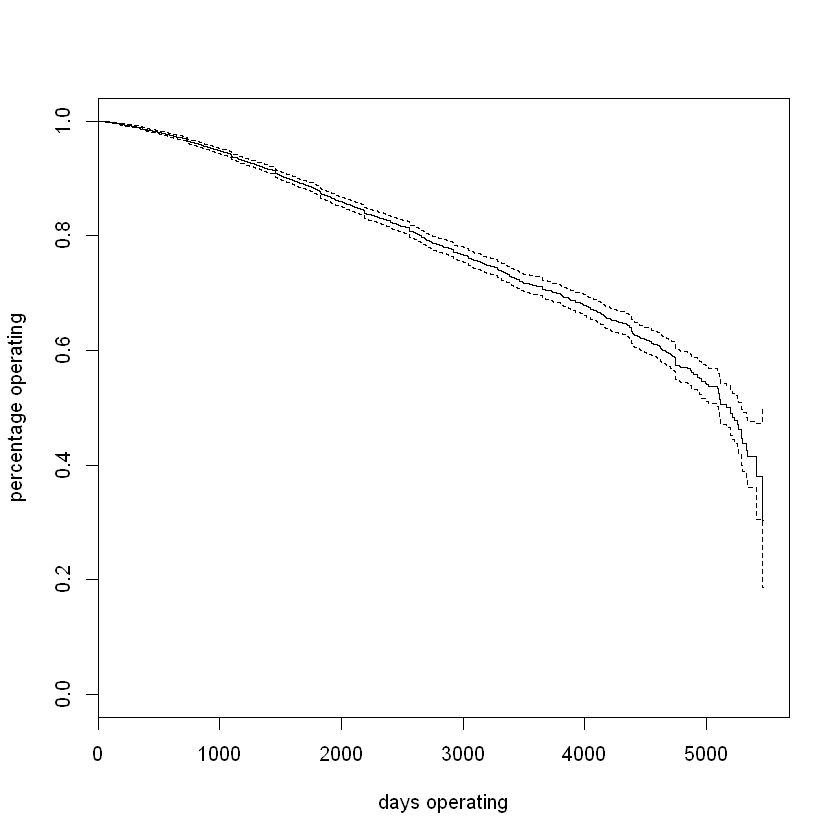

In [68]:
#fitting model
fit.KM <- survfit(surv_target ~ 1, data=surv_dataframe)
plot(fit.KM, xlab="days operating", ylab="percentage operating")